<a href="https://colab.research.google.com/github/aayushpe/Political-Sentiment-Analysis/blob/main/Analysis_With_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instantiate BERT model

In [ ]:
# BERT reference: https://www.kaggle.com/models/tensorflow/bert
#!pip install tensorflow_hub tensorflow_text -> run if needed
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
preprocess_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
encoder_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

In [ ]:
# Instatiate bert preprocessor
bert_preprocessor = hub.KerasLayer(preprocess_url)

# Preprocess the Text

In [ ]:
# Create text
test_text = ['Hello, nice to meet you', 'What are you doing?']

# Preprocess the text
preprocessed_text = bert_preprocessor(test_text)

# Keys returned from the preprocessed text
print(preprocessed_text.keys())

dict_keys(['input_word_ids', 'input_mask', 'input_type_ids'])


In [ ]:
# Shows the word ids for each word
print(preprocessed_text['input_word_ids'])

tf.Tensor(
[[ 101 7592 1010 3835 2000 3113 2017  102    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 101 2054 2024 2017 2725 1029  102    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    

# Convert the text into its word embeddings

In [ ]:
# Instatiate the Bert encoder to get the word embeddings
bert_model = hub.KerasLayer(encoder_url)

# Get the word embeddings from text defined earlier
word_embeddings = bert_model(preprocessed_text)

# View the word embeddings' keys
print(word_embeddings.keys())

dict_keys(['sequence_output', 'default', 'pooled_output', 'encoder_outputs'])


In [ ]:
# Show the embeddings for both scentences in the text
word_embeddings['pooled_output']

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.81532586, -0.35415214, -0.6993125 , ..., -0.5375053 ,
        -0.6587657 ,  0.82100445],
       [-0.94741714, -0.43736768, -0.94282895, ..., -0.7328504 ,
        -0.741358  ,  0.96136224]], dtype=float32)>

# Now that the sentences have been coverted to embeddings, it can be used in a neural network for different applications



Once we Have our political sentiment data, we can recreate the steps below in order to train our model.

For now, I tested it on a dataset for spam emails. This will be a simple neural network with a final softmax layer and an output of 2 for binary classification. When we are working with our political sentiment analysis data, we would need more (left leaning, right leaning, etc..)

# Process Data

In [ ]:
# Read in file
data = pd.read_csv('spam.csv', encoding='latin1')

# Show some data
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


<Axes: >

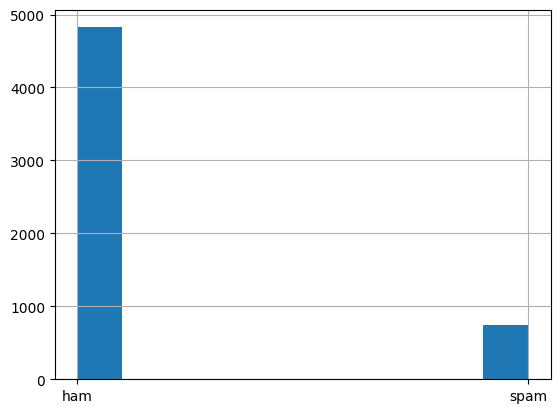

In [ ]:
# Show data Imbalance
data['v1'].hist()

In [ ]:
# Seperate only spam data
data_spam = data[data['v1'] == 'spam']
data_spam.shape

(747, 5)

In [ ]:
# Seperate only non-spam data
data_ham = data[data['v1'] == 'ham']
data_ham.shape

(4825, 5)

In [ ]:
# Down sample non-spam data to avoid overfitting
data_ham_downsampled = data_ham.sample(data_spam.shape[0])
data_ham_downsampled.shape

(747, 5)

In [ ]:
# Merge samples backtogether again
final_data = pd.concat([data_spam, data_ham_downsampled])
final_data.shape

(1494, 5)

v1
spam    747
ham     747
Name: count, dtype: int64


<Axes: >

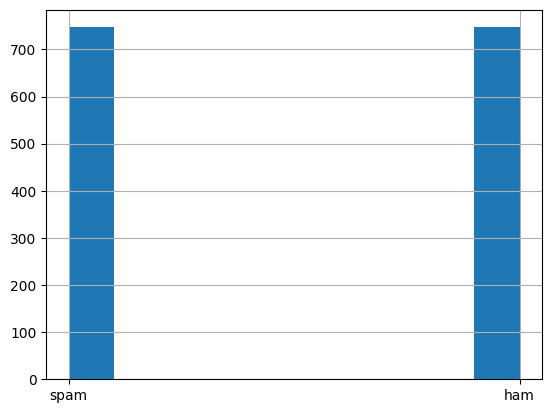

In [ ]:
# Check downsampled dataset
print(final_data['v1'].value_counts())
final_data['v1'].hist()

In [ ]:
print('Shape of final data: ' + str(final_data.shape))
final_data.sample(5)

Shape of final data: (1494, 5)


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
2974,ham,"Don't worry, * is easy once have ingredients!",NaN,NaN,NaN
4883,ham,For many things its an antibiotic and it can b...,NaN,NaN,NaN
3197,ham,7 lor... Change 2 suntec... Wat time u coming?,NaN,NaN,NaN
3842,ham,Yes ammae....life takes lot of turns you can o...,NaN,NaN,NaN
4434,spam,Don't b floppy... b snappy & happy! Only gay c...,NaN,NaN,NaN


In [ ]:
# Convert spam and ham to 1s and 0s and store it in a new column named spam
final_data['spam'] = final_data['v1'].apply(lambda x: 1 if x=='spam' else 0)
final_data.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,spam
988,ham,Yun ah.the ubi one say if Ì_ wan call by tomor...,NaN,NaN,NaN,0
591,spam,You have been specially selected to receive a ...,NaN,NaN,NaN,1
5377,spam,The current leading bid is 151. To pause this ...,NaN,NaN,NaN,1
2698,spam,FROM 88066 LOST å£12 HELP,NaN,NaN,NaN,1
5098,spam,TheMob>Hit the link to get a premium Pink Pant...,NaN,NaN,NaN,1


# Get word embeddings for data

In [ ]:
# Make training and testing split with data
X_train, X_test, y_train, y_test = train_test_split(final_data.drop(['v1', 'spam', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 2'], axis=1),
                                                    final_data['spam'],
                                                    stratify=final_data['spam'])

# final_data.drop(['v1', 'spam', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 2'], axis=1 takes in only v2 column

In [ ]:
X_train.sample(10)

,v2
2002,TheMob>Yo yo yo-Here comes a new selection of ...
2692,Urgent Urgent! We have 800 FREE flights to Eur...
1046,Do 1 thing! Change that sentence into: \Becaus...
1255,Just wait till end of march when el nino gets ...
3999,This is the 2nd time we have tried to contact ...
269,Ringtone Club: Get the UK singles chart on you...
5102,This msg is for your mobile content order It h...
1358,If i start sending blackberry torch to nigeria...
4590,Well done ENGLAND! Get the official poly ringt...
2768,I am on the way to ur home


In [ ]:
# Defines a function to get the scentence embeddings for each entry
def get_sentence_embedding(sentences):
  # preprocess words
  preprocessed_text = bert_preprocessor(sentences)

  # get embedding vectors from the pooled_output key
  return bert_model(preprocessed_text)['pooled_output']

# Small scale driver to test function
get_sentence_embedding([
    'WINNER! As a valued network customer you hvae',
    'Kit Strip - you have been billed 150p'
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.88051075, -0.38316447, -0.6248541 , ..., -0.42129242,
        -0.62962216,  0.8746777 ],
       [-0.5142308 , -0.39385262, -0.8937217 , ..., -0.79512   ,
        -0.46174598,  0.6317932 ]], dtype=float32)>

In [ ]:
# Get embeddings for training set
X_train_embeddings = get_sentence_embedding(X_train['v2'])

# Get embeddings for testing set
X_test_embeddings = get_sentence_embedding(X_test['v2'])

In [ ]:
# Before and after word embeddings
print('Before' + str(X_train.shape))
print('After' + str(X_train_embeddings.shape))

Before(1120, 1)
After(1120, 768)


In [ ]:
# Convert the y vectors for the softmax function
y_train_one_hot = to_categorical(y_train, num_classes=2)
y_test_one_hot = to_categorical(y_test, num_classes=2)

# Create Neural Network


In [ ]:
model = tf.keras.Sequential([
    # Input layer matches the size of BERT's pooled_output
    tf.keras.layers.Input(shape=(768,), name='text'),

    # Dense layer with 50 neurons and ReLU activation
    tf.keras.layers.Dense(50, activation = 'relu', name='hidden'),

    # Drouput layer
    tf.keras.layers.Dropout(0.1),

    # Output layer with sigmoid activation for binary classification
    tf.keras.layers.Dense(2, activation='softmax', name='output')
])

In [ ]:
# Get the model's summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ hidden (Dense)                       │ (None, 50)                  │          38,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,552 (150.59 KB)

 Trainable params: 38,552 (150.59 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model.compile (
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall'],
)

In [ ]:
# Start training
results = model.fit(
    X_train_embeddings,
    y_train_one_hot,
    epochs = 10
)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9551 - loss: 0.1485 - precision: 0.9551 - recall: 0.9551
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9641 - loss: 0.1254 - precision: 0.9641 - recall: 0.9641
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9559 - loss: 0.1411 - precision: 0.9559 - recall: 0.9559
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9615 - loss: 0.1201 - precision: 0.9615 - recall: 0.9615
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9670 - loss: 0.1172 - precision: 0.9670 - recall: 0.9670
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9575 - loss: 0.1320 - precision: 0.9575 - recall: 0.9575
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9611 - loss: 0.1240 - precision: 0.9611 - recall: 0.9611
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9693 - loss: 0.1177 - precision: 0.9693 - recall: 0.9693
Epoch 9/10
35/35 ━━━━━━━━━━━━━━━

In [ ]:
model.evaluate(X_test_embeddings, y_test_one_hot)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9668 - loss: 0.0990 - precision: 0.9668 - recall: 0.9668


[0.09481852501630783, 0.970588207244873, 0.970588207244873, 0.970588207244873]

# Results

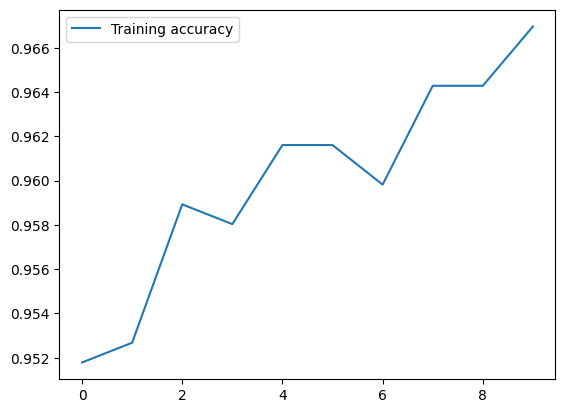

In [ ]:
# Plot Accuracy
plt.plot(results.history['accuracy'], label='Training accuracy')
plt.legend()

In [ ]:
import numpy as np

# Sample predictions from a softmax output
y_predicted = model.predict(X_test_embeddings)  # Softmax predictions

# Get the predicted class by finding the index of the maximum value along axis 1 (per row)
y_predicted_classes = np.argmax(y_predicted, axis=1)  # Resulting in class labels

# Check the predicted class labels
print("Predicted classes:", y_predicted_classes)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted classes: [1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1
 0 1 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 1 1 1 0 0 1 0 0 1
 0 0 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 1 0 1 0 0
 0 1 1 1 0 0 0 0 1 0 1 1 0 1 1 0 1 1 0 0 1 0 1 1 0 1 0 0 1 1 1 0 1 0 0 1 1
 1 1 1 1 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1
 0 0 0 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0 1 0 1
 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1
 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 0 0 0 1 1 1 0 1 1 1 0 0 1 1 1 0 1 0
 1 0 1 1 1 1 1 1 1 0 1 0 0 0 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1
 0 0 0 0]


In [ ]:
X_test.head()

,v2
3407,Do you want a New Nokia 3510i colour phone Del...
4744,Camera - You are awarded a SiPix Digital Camer...
4627,Todays Voda numbers ending with 7634 are selec...
3913,Today is ACCEPT DAY..U Accept me as? Brother S...
357,Ur cash-balance is currently 500 pounds - to m...


In [ ]:
# Loop through the first 20 samples
for i in range(20):
    sample_text = X_test.iloc[i]['v2'] # The original text for the sample
    prediction = y_predicted_classes[i]  # The predicted output (0 or 1)

    # Convert the prediction to a human-readable label
    if prediction == 0:
        label = "Not spam"
    elif prediction == 1:
        label = "Spam"

    # Display the sample text and its predicted output
    print(f"Sample {i+1}: '{sample_text}'")
    print(f"Prediction: {label} \n")


Sample 1: 'Do you want a New Nokia 3510i colour phone DeliveredTomorrow? With 300 free minutes to any mobile + 100 free texts + Free Camcorder reply or call 08000930705'
Prediction: Spam 

Sample 2: 'Camera - You are awarded a SiPix Digital Camera! call 09061221066 fromm landline. Delivery within 28 days.'
Prediction: Spam 

Sample 3: 'Todays Voda numbers ending with 7634 are selected to receive a å£350 reward. If you have a match please call 08712300220 quoting claim code 7684 standard rates apply.'
Prediction: Spam 

Sample 4: 'Today is ACCEPT DAY..U Accept me as? Brother Sister Lover Dear1 Best1 Clos1 Lvblefrnd Jstfrnd Cutefrnd Lifpartnr Belovd Swtheart Bstfrnd No rply means enemy'
Prediction: Not spam 

Sample 5: 'Ur cash-balance is currently 500 pounds - to maximize ur cash-in now send CASH to 86688 only 150p/msg. CC: 08708800282 HG/Suite342/2Lands Row/W1J6HL'
Prediction: Spam 

Sample 6: 'Orange brings you ringtones from all time Chart Heroes, with a free hit each week! Go to Rin

Confusion Matrix:
[[181   6]
 [  5 182]]


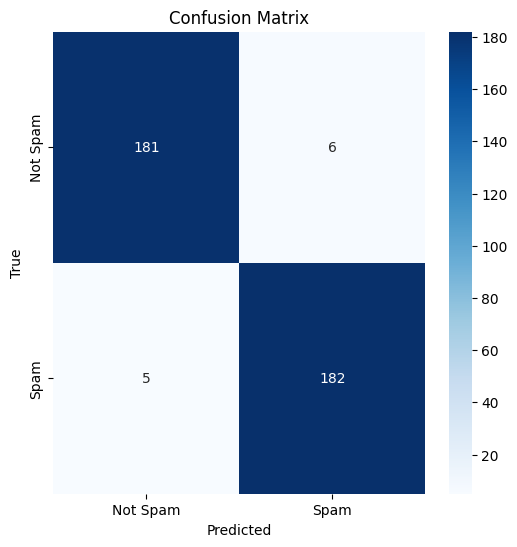

In [ ]:
# Assuming softmax predictions from the model
y_predicted_classes = np.argmax(y_predicted, axis=1)  # Convert softmax predictions to class labels

# Converting one-hot labels to class labels
y_test_classes = np.argmax(y_test_one_hot, axis=1)  # From one-hot to class labels

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_predicted_classes)  # True vs. predicted classes

# Print the confusion matrix to see the raw data
print("Confusion Matrix:")
print(conf_matrix)

# Optional: Visualize the confusion matrix with a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
